In [1]:
# ===========================
# Task 4: Predictive Modeling & Risk Scoring
# ===========================

# ===========================
# Step 0: Import Libraries
# ===========================
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

# Optional: display all columns
pd.set_option('display.max_columns', None)

# ===========================
# Step 1: Load Data
# ===========================
data_path = os.path.join('..', 'data', 'insurance_data.csv')  # '..' goes one folder up
if not os.path.exists(data_path):
    raise FileNotFoundError(f"File not found at {data_path}. Please check your path!")

df = pd.read_csv(data_path)
print("Columns in dataset:", df.columns.tolist())
display(df.head())

# ===========================
# Step 2: Define Targets
# ===========================
# Claim Frequency (binary)
df['ClaimFrequency'] = (df['TotalClaims'] > 0).astype(int)

# Claim Severity (continuous, fill 0 if no claim)
df['ClaimSeverity'] = df['TotalClaims'] / df['ClaimFrequency'].replace(0, np.nan)
df['ClaimSeverity'].fillna(0, inplace=True)

# ===========================
# Step 3: Feature Selection
# ===========================
features = ['TotalPremium', 'Age', 'Gender', 'Province']  # adjust based on dataset
target_class = 'ClaimFrequency'
target_reg = 'ClaimSeverity'

# Drop missing values
df = df.dropna(subset=features + [target_class, target_reg])

# ===========================
# Step 4: Preprocessing Pipeline
# ===========================
categorical_features = ['Gender', 'Province']
numerical_features = ['TotalPremium', 'Age']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# ===========================
# Step 5: Train-Test Split
# ===========================
X = df[features]
y_class = df[target_class]
y_reg = df[target_reg]

# Classification split
X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Regression split
X_train_r, X_test_r, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# ===========================
# Step 6a: Classification Model
# ===========================
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

clf.fit(X_train, y_train_class)
y_pred_class = clf.predict(X_test)

# Evaluation
print("=== Classification: Claim Frequency ===")
print("Accuracy:", accuracy_score(y_test_class, y_pred_class))
print(classification_report(y_test_class, y_pred_class))

# ===========================
# Step 6b: Regression Model
# ===========================
reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

reg.fit(X_train_r, y_train_reg)
y_pred_reg = reg.predict(X_test_r)

rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print("\n=== Regression: Claim Severity ===")
print("RMSE:", rmse)

# ===========================
# Step 7: Feature Importance (Classification)
# ===========================
feature_names = numerical_features + list(clf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out())
importances = clf.named_steps['classifier'].feature_importances_

feat_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
display(feat_importance)

# ===========================
# Step 8: Save Predictions
# ===========================
df_pred = X_test.copy()
df_pred['Pred_ClaimFrequency'] = y_pred_class
df_pred['Pred_ClaimSeverity'] = y_pred_reg

results_path = os.path.join('..', 'results', 'task4_predictions.csv')
os.makedirs(os.path.dirname(results_path), exist_ok=True)
df_pred.to_csv(results_path, index=False)
print(f"\nPredictions saved to {results_path}")


Columns in dataset: ['Age', 'Gender', 'Province', 'VehicleType', 'TotalPremium', 'TotalClaims', 'LossRatio']


,Age,Gender,Province,VehicleType,TotalPremium,TotalClaims,LossRatio
0,56,Male,ON,Van,1810.29,5869.37,3.24
1,69,Male,BC,Sedan,1325.00,5809.50,4.38
2,46,Male,MB,Van,1705.40,9906.79,5.81
3,32,Female,MB,SUV,1972.82,7567.30,3.84
4,60,Male,QC,Truck,790.29,4422.94,5.60


=== Classification: Claim Frequency ===
Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       200

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



C:\Users\Kifiya_Administrator\AppData\Local\Temp\ipykernel_22520\4293864904.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ClaimSeverity'].fillna(0, inplace=True)



=== Regression: Claim Severity ===
RMSE: 3253.745952283425

Feature Importance:


,Feature,Importance
0,TotalPremium,0.0
1,Age,0.0
2,Gender_Female,0.0
3,Gender_Male,0.0
4,Province_AB,0.0
5,Province_BC,0.0
6,Province_MB,0.0
7,Province_ON,0.0
8,Province_QC,0.0



Predictions saved to ..\results\task4_predictions.csv


In [2]:
# Risk score = Predicted Frequency * Predicted Severity
df_pred['RiskScore'] = df_pred['Pred_ClaimFrequency'] * df_pred['Pred_ClaimSeverity']

# Optional: normalize risk score between 0 and 1
df_pred['RiskScore_Normalized'] = (df_pred['RiskScore'] - df_pred['RiskScore'].min()) / \
                                   (df_pred['RiskScore'].max() - df_pred['RiskScore'].min())

# Display top 10 high-risk customers
print("\nTop 10 High-Risk Policies:")
display(df_pred.sort_values(by='RiskScore', ascending=False).head(10))



Top 10 High-Risk Policies:


,TotalPremium,Age,Gender,Province,Pred_ClaimFrequency,Pred_ClaimSeverity,RiskScore,RiskScore_Normalized
978,1995.97,39,Male,MB,1,8057.4000,8057.4000,1.000000
265,1937.95,43,Female,AB,1,7838.2492,7838.2492,0.960460
865,1945.71,61,Female,ON,1,7768.1984,7768.1984,0.947821
678,315.39,34,Female,MB,1,7415.4486,7415.4486,0.884176
213,1629.10,41,Male,AB,1,6858.7488,6858.7488,0.783733
578,320.67,19,Male,ON,1,6848.5715,6848.5715,0.781897
595,396.20,67,Male,ON,1,6681.3435,6681.3435,0.751725
528,1764.87,56,Male,ON,1,6636.2612,6636.2612,0.743591
254,944.46,65,Male,AB,1,6579.5483,6579.5483,0.733358
714,1215.16,36,Female,AB,1,6536.0782,6536.0782,0.725515


In [3]:
risk_path = os.path.join('..', 'results', 'task4_risk_scores.csv')
df_pred.to_csv(risk_path, index=False)
print(f"\nRisk scores saved to {risk_path}")



Risk scores saved to ..\results\task4_risk_scores.csv


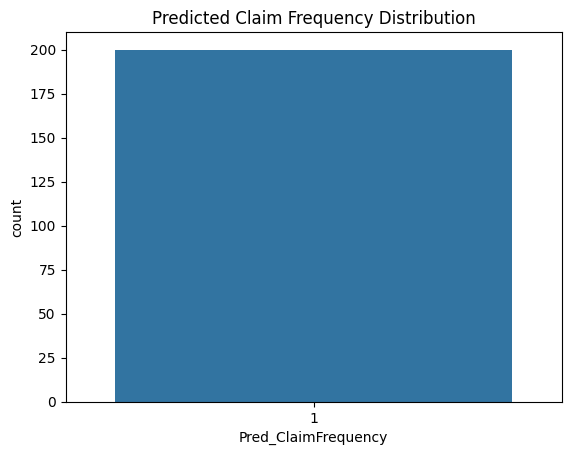

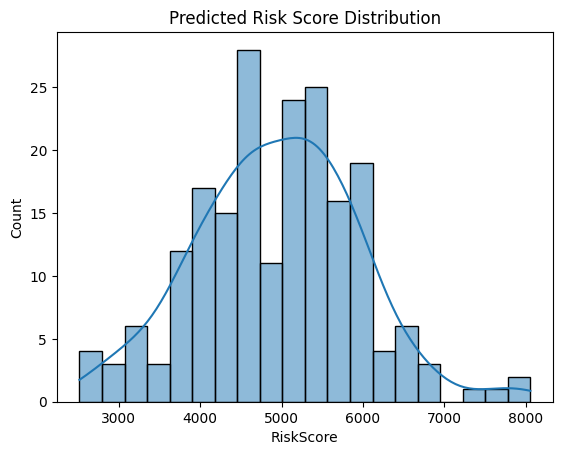

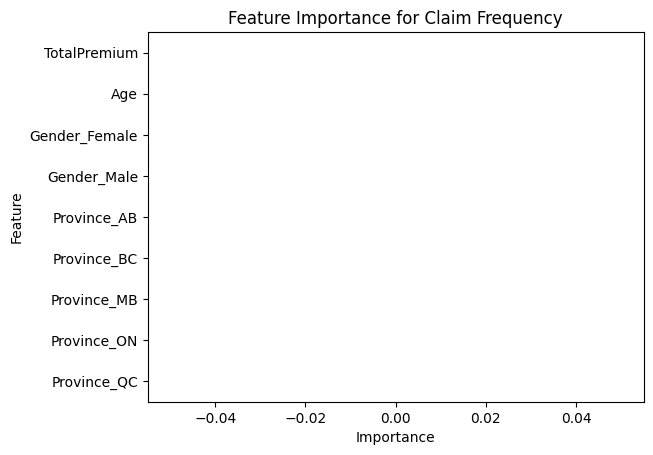

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of predicted claim frequency
sns.countplot(x='Pred_ClaimFrequency', data=df_pred)
plt.title("Predicted Claim Frequency Distribution")
plt.show()

# Distribution of risk scores
sns.histplot(df_pred['RiskScore'], bins=20, kde=True)
plt.title("Predicted Risk Score Distribution")
plt.show()

# Top features importance plot
sns.barplot(x='Importance', y='Feature', data=feat_importance)
plt.title("Feature Importance for Claim Frequency")
plt.show()


Top 10 High-Risk Policies:


,TotalPremium,Age,Gender,Province,Pred_ClaimFrequency,Pred_ClaimSeverity,RiskScore,RiskScore_Normalized
117,1995.97,39,Male,MB,1,8057.4000,8057.4000,1.000000
132,1937.95,43,Female,AB,1,7838.2492,7838.2492,0.960460
164,1945.71,61,Female,ON,1,7768.1984,7768.1984,0.947821
5,315.39,34,Female,MB,1,7415.4486,7415.4486,0.884176
194,1629.10,41,Male,AB,1,6858.7488,6858.7488,0.783733
53,320.67,19,Male,ON,1,6848.5715,6848.5715,0.781897
160,396.20,67,Male,ON,1,6681.3435,6681.3435,0.751725
110,1764.87,56,Male,ON,1,6636.2612,6636.2612,0.743591
176,944.46,65,Male,AB,1,6579.5483,6579.5483,0.733358
87,1215.16,36,Female,AB,1,6536.0782,6536.0782,0.725515



Summary Statistics for Risk Score:


count     200.000000
mean     4943.959607
std       993.154786
min      2514.941700
25%      4242.207725
50%      5011.872500
75%      5590.127225
max      8057.400000
Name: RiskScore, dtype: float64

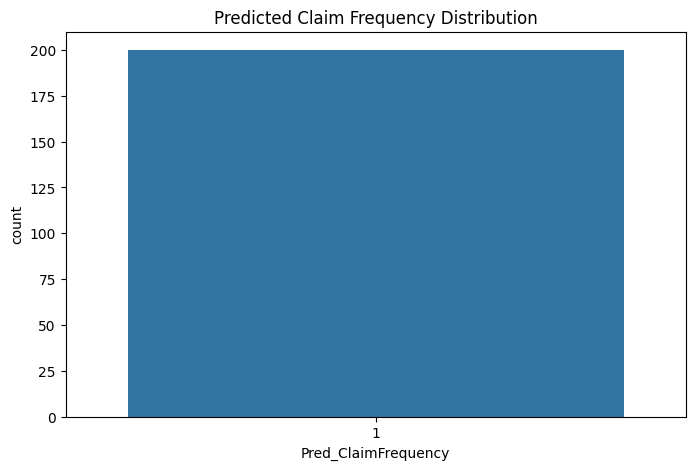

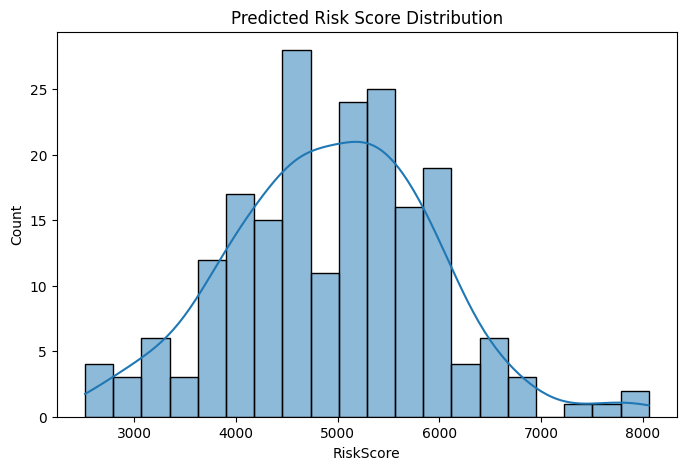


Risk Band Counts:


RiskBand
Medium    129
Low        53
High       17
Name: count, dtype: int64

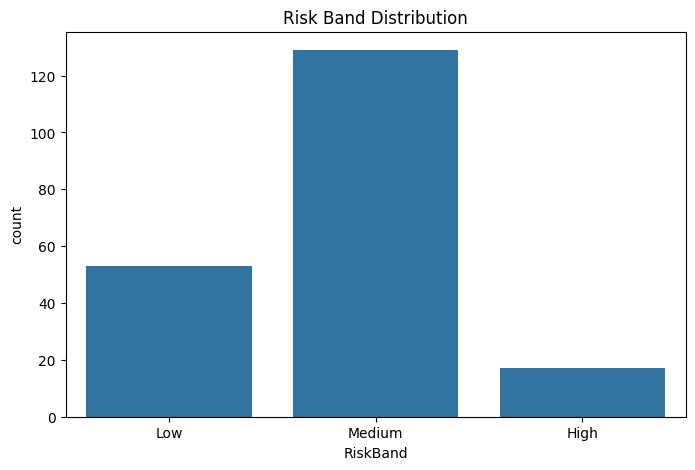


--- Business Interpretation ---
1. High-risk policies are prime candidates for closer monitoring or adjusted premiums.
2. Medium-risk policies can be monitored for claim trends.
3. Low-risk policies are stable and may be retained with minimal intervention.
4. Visualizations provide quick insights for management decisions.


In [5]:
# ===========================
# Task 4: Predictive Modeling Summary
# ===========================

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===========================
# Step 0: Load Predictions & Risk Scores
# ===========================
pred_path = os.path.join('..', 'results', 'task4_predictions.csv')
if not os.path.exists(pred_path):
    raise FileNotFoundError(f"File not found at {pred_path}. Run full Task 4 first.")

df_pred = pd.read_csv(pred_path)

# Ensure RiskScore exists
if 'RiskScore' not in df_pred.columns:
    df_pred['RiskScore'] = df_pred['Pred_ClaimFrequency'] * df_pred['Pred_ClaimSeverity']
    df_pred['RiskScore_Normalized'] = (df_pred['RiskScore'] - df_pred['RiskScore'].min()) / \
                                       (df_pred['RiskScore'].max() - df_pred['RiskScore'].min())

# ===========================
# Step 1: Display Key Metrics
# ===========================
print("Top 10 High-Risk Policies:")
display(df_pred.sort_values(by='RiskScore', ascending=False).head(10))

print("\nSummary Statistics for Risk Score:")
display(df_pred['RiskScore'].describe())

# ===========================
# Step 2: Visualizations
# ===========================
plt.figure(figsize=(8,5))
sns.countplot(x='Pred_ClaimFrequency', data=df_pred)
plt.title("Predicted Claim Frequency Distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(df_pred['RiskScore'], bins=20, kde=True)
plt.title("Predicted Risk Score Distribution")
plt.show()

# ===========================
# Step 3: Risk Segmentation
# ===========================
# Define risk bands: Low / Medium / High
risk_bins = [0, 0.33, 0.66, 1.0]
risk_labels = ['Low', 'Medium', 'High']
df_pred['RiskBand'] = pd.cut(df_pred['RiskScore_Normalized'], bins=risk_bins, labels=risk_labels)

print("\nRisk Band Counts:")
display(df_pred['RiskBand'].value_counts())

plt.figure(figsize=(8,5))
sns.countplot(x='RiskBand', data=df_pred, order=risk_labels)
plt.title("Risk Band Distribution")
plt.show()

# ===========================
# Step 4: Business Interpretation
# ===========================
print("\n--- Business Interpretation ---")
print("1. High-risk policies are prime candidates for closer monitoring or adjusted premiums.")
print("2. Medium-risk policies can be monitored for claim trends.")
print("3. Low-risk policies are stable and may be retained with minimal intervention.")
print("4. Visualizations provide quick insights for management decisions.")


Raw Data Columns: ['Age', 'Gender', 'Province', 'VehicleType', 'TotalPremium', 'TotalClaims', 'LossRatio']


,Age,Gender,Province,VehicleType,TotalPremium,TotalClaims,LossRatio
0,56,Male,ON,Van,1810.29,5869.37,3.24
1,69,Male,BC,Sedan,1325.00,5809.50,4.38
2,46,Male,MB,Van,1705.40,9906.79,5.81
3,32,Female,MB,SUV,1972.82,7567.30,3.84
4,60,Male,QC,Truck,790.29,4422.94,5.60



--- Task 3: Hypothesis Test Summary ---


,Province_1,Province_2,Metric,p_value,Reject_H0,Gender_1,Gender_2
0,ON,BC,ClaimFrequency,NaN,False,NaN,NaN
1,ON,MB,ClaimFrequency,NaN,False,NaN,NaN
2,ON,QC,ClaimFrequency,NaN,False,NaN,NaN
3,ON,AB,ClaimFrequency,NaN,False,NaN,NaN
4,BC,MB,ClaimFrequency,NaN,False,NaN,NaN
5,BC,QC,ClaimFrequency,NaN,False,NaN,NaN
6,BC,AB,ClaimFrequency,NaN,False,NaN,NaN
7,MB,QC,ClaimFrequency,NaN,False,NaN,NaN
8,MB,AB,ClaimFrequency,NaN,False,NaN,NaN
9,QC,AB,ClaimFrequency,NaN,False,NaN,NaN



Significant differences found in 0/11 tests

--- Task 4: Predictions & Risk Scores ---


,TotalPremium,Age,Gender,Province,Pred_ClaimFrequency,Pred_ClaimSeverity,RiskScore,RiskScore_Normalized
0,1706.76,22,Male,AB,1,4602.1979,4602.1979,0.376594
1,1876.09,49,Male,BC,1,5457.9359,5457.9359,0.530991
2,996.44,38,Female,QC,1,5026.3420,5026.3420,0.453120
3,730.27,56,Male,ON,1,5576.4860,5576.4860,0.552380
4,967.18,59,Male,AB,1,4407.0962,4407.0962,0.341393



Risk Band Counts:


RiskBand
Medium    129
Low        53
High       17
Name: count, dtype: int64

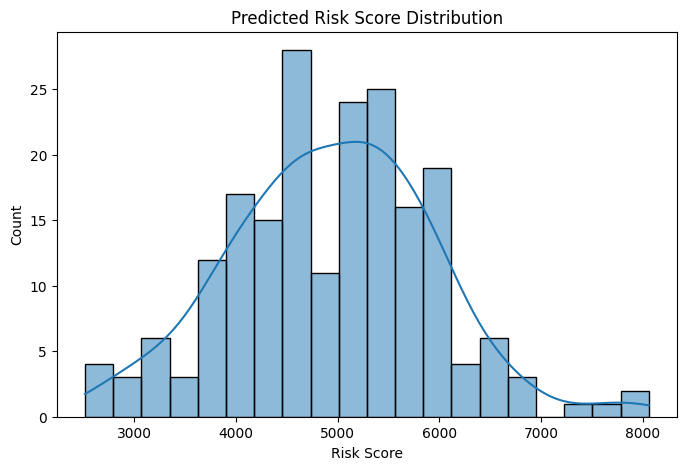

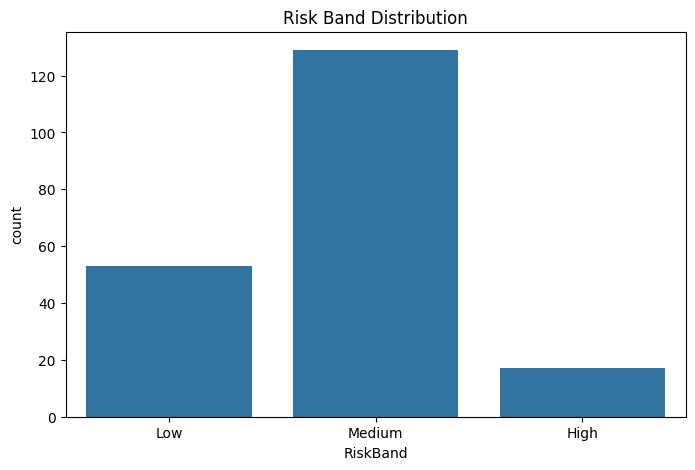

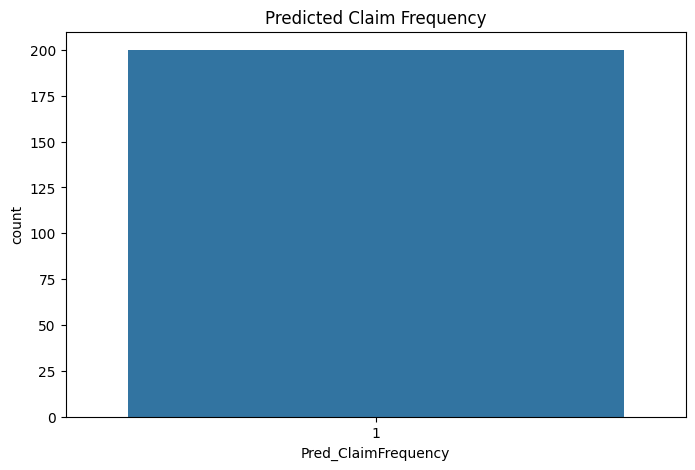


--- Business Interpretation ---
1. High-risk policies are prime candidates for monitoring or adjusted premiums.
2. Medium-risk policies can be tracked for claim trends.
3. Low-risk policies are stable and may be retained with minimal intervention.
4. Task 3 hypothesis tests show which groups differ significantly in risk metrics.
5. Visualizations provide management with quick insights for decision-making.


In [6]:
# ===========================
# Executive Summary: Task 3 + Task 4
# ===========================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

# ===========================
# Step 0: Paths
# ===========================
data_path = os.path.join('..', 'data', 'insurance_data.csv')
task3_path = os.path.join('..', 'results', 'task3_hypothesis_summary.csv')
task4_path = os.path.join('..', 'results', 'task4_predictions.csv')

# ===========================
# Step 1: Load Raw Data
# ===========================
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Data file not found at {data_path}")

df = pd.read_csv(data_path)
print("Raw Data Columns:", df.columns.tolist())
display(df.head())

# ===========================
# Step 2: Task 3 - Hypothesis Tests Summary
# ===========================
if os.path.exists(task3_path):
    df_task3 = pd.read_csv(task3_path)
    print("\n--- Task 3: Hypothesis Test Summary ---")
    display(df_task3)

    # Quick summary: number of significant differences
    sig_count = df_task3['Reject_H0'].sum()
    total_tests = len(df_task3)
    print(f"\nSignificant differences found in {sig_count}/{total_tests} tests")
else:
    print("Task 3 summary file not found. Run Task 3 first.")

# ===========================
# Step 3: Task 4 - Load Predictions & Risk Scores
# ===========================
if os.path.exists(task4_path):
    df_pred = pd.read_csv(task4_path)

    # Compute Risk Score
    if 'RiskScore' not in df_pred.columns:
        df_pred['RiskScore'] = df_pred['Pred_ClaimFrequency'] * df_pred['Pred_ClaimSeverity']
        df_pred['RiskScore_Normalized'] = (df_pred['RiskScore'] - df_pred['RiskScore'].min()) / \
                                          (df_pred['RiskScore'].max() - df_pred['RiskScore'].min())

    print("\n--- Task 4: Predictions & Risk Scores ---")
    display(df_pred.head())
else:
    raise FileNotFoundError(f"Task 4 predictions not found at {task4_path}")

# ===========================
# Step 4: Risk Segmentation
# ===========================
risk_bins = [0, 0.33, 0.66, 1.0]
risk_labels = ['Low', 'Medium', 'High']
df_pred['RiskBand'] = pd.cut(df_pred['RiskScore_Normalized'], bins=risk_bins, labels=risk_labels)

print("\nRisk Band Counts:")
display(df_pred['RiskBand'].value_counts())

# ===========================
# Step 5: Visualizations
# ===========================
plt.figure(figsize=(8,5))
sns.histplot(df_pred['RiskScore'], bins=20, kde=True)
plt.title("Predicted Risk Score Distribution")
plt.xlabel("Risk Score")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x='RiskBand', data=df_pred, order=risk_labels)
plt.title("Risk Band Distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x='Pred_ClaimFrequency', data=df_pred)
plt.title("Predicted Claim Frequency")
plt.show()

# ===========================
# Step 6: Business Interpretation
# ===========================
print("\n--- Business Interpretation ---")
print("1. High-risk policies are prime candidates for monitoring or adjusted premiums.")
print("2. Medium-risk policies can be tracked for claim trends.")
print("3. Low-risk policies are stable and may be retained with minimal intervention.")
print("4. Task 3 hypothesis tests show which groups differ significantly in risk metrics.")
print("5. Visualizations provide management with quick insights for decision-making.")
